## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.


**Описание данных:**
- datetime — дата и время заказа; 
- num_orders — количество заказов.


## Изучение общей информации о датасете

In [1]:
!pip install --upgrade matplotlib -q

In [2]:
!pip install --upgrade pandas -q

In [3]:
!pip install numpy==1.24.4 -q

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np
import time

from lightgbm import LGBMRegressor

from statsmodels.tsa.seasonal import seasonal_decompose

from matplotlib.pyplot import rcParams, rcParamsDefault
from matplotlib import transforms
from scipy import stats as st
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf

In [6]:
# настроим параметры графиков
rcParams['figure.figsize'] = 8,4
%config InlineBackend.figure_format = 'svg'
factor = 0.8
default_dpi = rcParamsDefault['figure.dpi']
rcParams['figure.dpi'] = default_dpi * factor

In [7]:
# Создадим функцию для получения первичной информации по датасету.
def get_data_info(data):
    display(data.sample(3))
    display(data.info())
    display(data.describe(include='all'))

In [8]:
# функция для загрузки данных из локального файла или URL.
def load_data(local_path, url):
    try:
        if os.path.exists(local_path):
            data = pd.read_csv(local_path, index_col=[0], parse_dates = ['datetime'])
            print('Данные успешно загружены из локального файла.')
            return data
        else:
            print('Локальный файл не найден, загрузка с URL...')
            raise FileNotFoundError
    except Exception as e:
        print('Ошибка при загрузке данных из локального файла:', e)
    
    # Попытка загрузки из URL
    try:
        data = pd.read_csv(url, index_col=[0], parse_dates = ['datetime'])
        print('Данные успешно загружены из URL.')
        return data
    except Exception as e:
        print('Ошибка при загрузке данных из URL:', e)
        return None

In [9]:
data = load_data('/Users/gulnaravolodina/Downloads/taxi.csv', 
                 'https://code.s3.yandex.net/datasets/taxi.csv')

Локальный файл не найден, загрузка с URL...
Ошибка при загрузке данных из локального файла: 
Данные успешно загружены из URL.


In [10]:
get_data_info(data)

,num_orders
datetime,
2018-03-08 15:10:00,4
2018-03-05 22:20:00,12
2018-06-09 20:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [11]:
# проверим, расположенные ли данные в хронологическом порядке
display(data.index.is_monotonic_increasing)

True

### Выводы, полученные после изучения общей информации о датасете
При чтении файла был заменен тип данных на datetime64 в признаке 'datetime'. В остальных признаках тип данных соответствует значениям.
Пропусков в данных нет. Признак datetime при чтении таблицы установили равным индексу таблицы
Явных дубликатов в таблице нет.
Данных достаточно для анализа. Данные расположены в хронологическом порядке

## Предобработка и исследовательский анализ данных

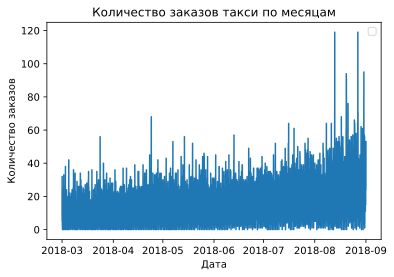

In [12]:
# построим график временного ряда, отсортировав индекс в хронологическом порядке.
data.sort_index(inplace=True)
plt.plot(data)
plt.xlabel("Дата")
plt.ylabel("Количество заказов")
plt.title("Количество заказов такси по месяцам")
plt.legend()
plt.show()

In [13]:
# проведeм ресемплирование, выбрав новый интервал временного ряда, равный 60 минутам
data = data.resample('1H').sum()

In [14]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Минимальное количество заказов за час 0, максимальное 462 заказа, медиана 78

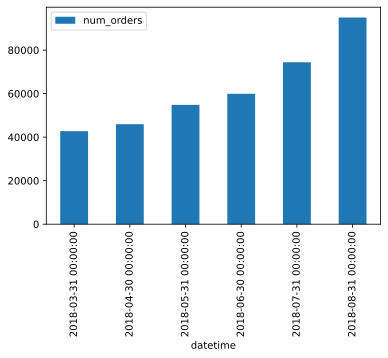

In [15]:
_ = data.resample('M').sum().plot(kind='bar')

Виден восходящий тренд по количеству заказов при разбивке по месяцам

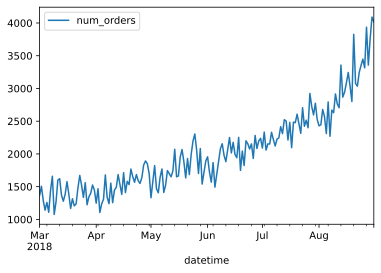

In [16]:
_ = data.resample('1D').sum().plot()

При ресемплировании данных по 1 дню восходящий тренд более выражен

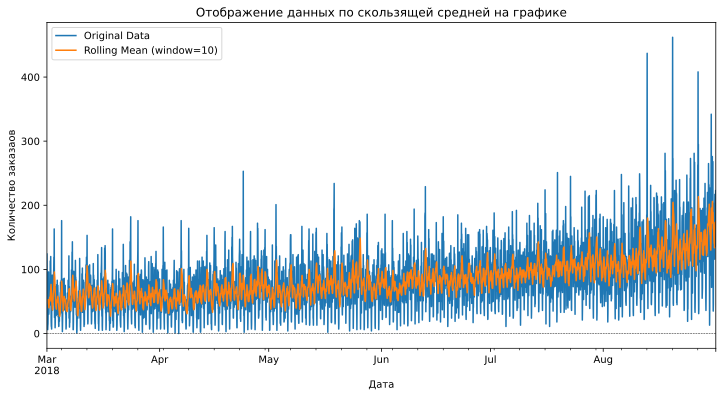

In [17]:
# отобразим скользящее среднее, экспериментальным путем подобрав размер окна 10, чтобы сгладить временные ряды
df = data.copy()
df['rolling_mean'] = df.rolling(window=10).mean()

# Построение графика
df.plot(figsize=(12, 6), title='Отображение данных по скользящей средней на графике')
plt.axhline(0, color='black', lw=0.5, ls='--') 
plt.xlabel("Дата")
plt.ylabel("Количество заказаов")
plt.legend(['Original Data', 'Rolling Mean (window=10)'])
plt.show()

Разложим временной ряд на тренд и сезонную компоненту.

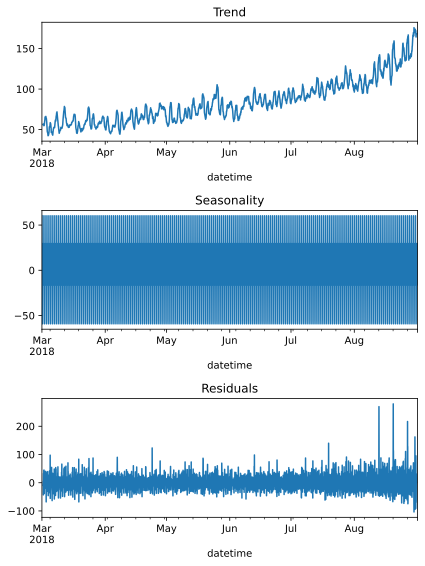

In [18]:
rcParams['figure.figsize'] = 9, 9
decomposed = seasonal_decompose(data)

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

На графике четко виден восходящий тренд, сезонность невозможно определить, остатки распределены хаотично.

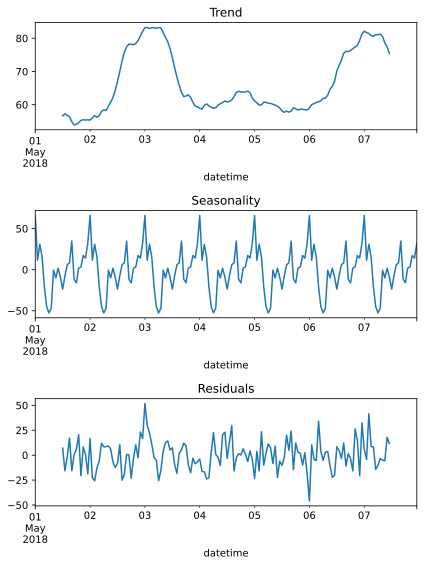

In [19]:
# посмотрим данные по 1 неделе
rcParams['figure.figsize'] = 9, 9
decomposed = seasonal_decompose(data['2018-05-01':'2018-05-07'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

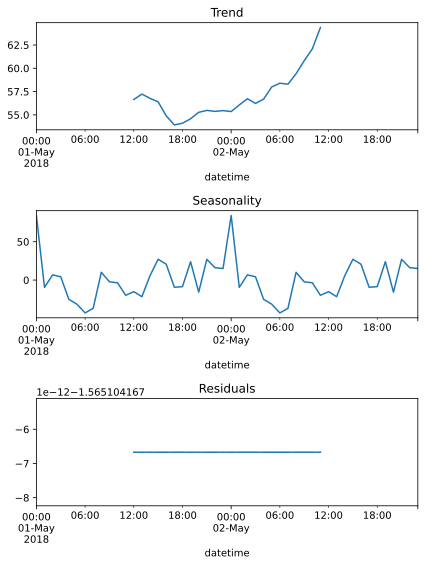

In [20]:
# посмотрим данные по 1 дню
rcParams['figure.figsize'] = 9, 9
decomposed = seasonal_decompose(data['2018-05-01':'2018-05-02'])

plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

При анализе заказов в разбивке по неделе четко видны тренд и сезонность, увеличение количества заказов после 19-20:00 и сокращение количества заказов после полуночи с минимумом в 06 утра.

<Axes: xlabel='datetime'>

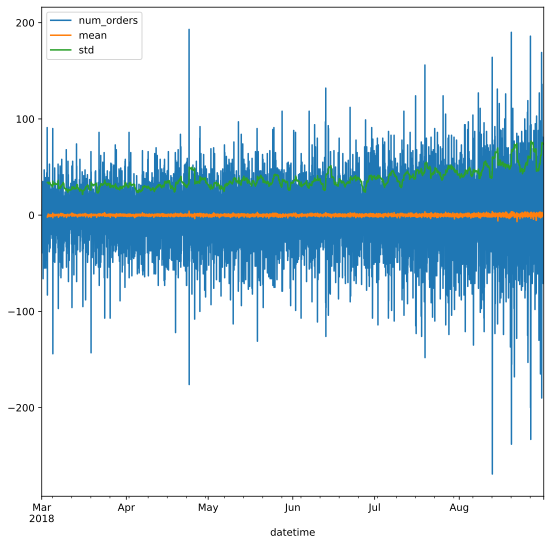

In [21]:
data_1 = data.copy()
data_1 = data_1 - data_1.shift()
data_1['mean'] = data_1['num_orders'].rolling(50).mean()
data_1['std'] = data_1['num_orders'].rolling(50).std()
data_1.plot()

Временной ряд стал более стационарным, значит, данные можно прогнозировать.

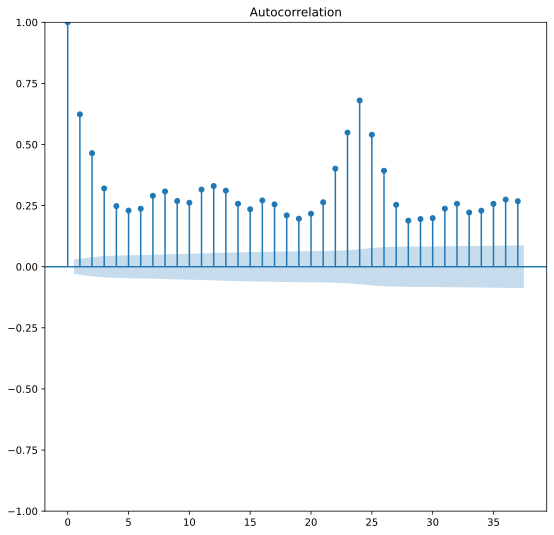

In [22]:
# посмотрим на автокорреляцию данных
plot_acf(data)
plt.show()

Лаг 12 и 24 сильнее коррелируют с исходным рядом, чем соседние лаги. Так как корреляция постоянно положительная, есть наличие тренда.

### Выводы по этапу предобработки и исследованию данных
Был построен график с учетом упорядочивания индекса (даты) в хронологическом порядке.
Проведено ресемплирование, выбрав новый интервал временного ряда, равный 60 минутам.
При ресемплировании данных по 1 дню и 1 месяцу четко виден восходящий тренд, временной ряд нестационарен, что будет мешать прогнозированию.
При разложении временного ряда на тренд и сезонную компоненту также видны тренд и сезонность.
Вычисление разности временного ряда и отображения на графике скользящего среднего и скользящего стандартного отклонения позволило сделать ряд более стационарным.
При построении графика автокорреляции видно, что лаг 12 и 24 сильнее коррелируют с исходным рядом, чем соседние.

## Поиск и проверка моделей для прогнозирования

In [23]:
df = data.copy()

In [24]:
# создадим функцию для добавления новых календарных признаков 
def make_features(df, max_lag, rolling_mean_size):
    df_copy = df.copy()
    df_copy['month'] = df_copy.index.month
    df_copy['day'] = df_copy.index.day
    df_copy['hour'] = df_copy.index.hour
    #вычислим отстающие значения
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)
    # вычислим скользящее среднее и добавим его как новый признак    
    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_copy

new_df = make_features(df, 24, 10)
print(df.head())

                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


In [25]:
new_df = new_df.dropna()

In [26]:
X = new_df.drop(columns=['num_orders'])  # Признаки
y = new_df['num_orders']  # Целевая переменная

# Разделим данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# DataFrame для обучающей выборки
train = pd.DataFrame(X_train)
train['num_orders'] = y_train.values  

# DataFrame для тестовой выборки
test = pd.DataFrame(X_test)
test['num_orders'] = y_test.values  

# Проверяем размеры
print(f"Размер X_train: {X_train.shape}")
print(f"Размер y_train: {y_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_test: {y_test.shape}")
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

Размер X_train: (3952, 28)
Размер y_train: (3952,)
Размер X_test: (440, 28)
Размер y_test: (440,)
2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [27]:
# функция для для визуализации фактических и предсказанных значений временного ряда
def plot_predictions_vs_actuals(predictions, target_test):

    # Создание DataFrame с фактическими и предсказанными значениями
    model_data = pd.DataFrame({
        "Фактические значения": target_test,
        "Предсказанные значения": predictions
    })
    
    # Общий график фактических и предсказанных значений
    plt.figure(figsize=(14, 6))
    plt.plot(model_data.index, model_data["Фактические значения"], label='Фактические значения', color='blue')
    plt.plot(model_data.index, model_data["Предсказанные значения"], label='Предсказанные значения', color='orange', linestyle='--')
    
    # Настройка графика
    plt.title('Сравнение фактических и предсказанных значений', fontsize=14)
    plt.xlabel('Дата', fontsize=6)
    plt.ylabel('Значения', fontsize=6)
    plt.legend()
    plt.grid()
    plt.show()

    # Сужение графика до заданного диапазона
    plt.figure(figsize=(14, 6))
    model_data['2018-08-30':'2018-08-31'].plot(title='Сравнение на более узком диапазоне', figsize=(14, 6))
    
    # Добавление настроек графика
    plt.title('Фактические и предсказанные значения с 30 по 31 августа 2018 года', fontsize=14)
    plt.xlabel('Дата', fontsize=6)
    plt.ylabel('Значения', fontsize=6)
    plt.legend(['Фактические значения', 'Предсказанные значения'])
    plt.grid()
    plt.show()

### Ridge

In [28]:
# создадим функцию для проверки точности модели и времени обучения и предсказания
def train_and_evaluate_model(model, param_grid, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    rz_search = RandomizedSearchCV(estimator=model, 
                                   param_distributions=param_grid,
                                   scoring='neg_mean_squared_error',  # Указываем, что будем использовать отрицательное MSE
                                   cv=tscv,
                                   n_iter=10,  # Количество итераций для поиска
                                   random_state=42)

    # время обучения
    start_fit_time = time.time()
    rz_search.fit(X_train, y_train)
    training_time = time.time() - start_fit_time
    
    best_params = rz_search.best_params_
    
    # время прогнозирования
    start_predict_time = time.time()
    y_pred_train = rz_search.predict(X_train)
    prediction_time = time.time() - start_predict_time
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    print(f"Лучшие параметры: {best_params}")
    print(f"RMSE на обучающей выборке: {rmse_train:.4f}")
    print(f"Время обучения модели: {training_time:.4f} секунд")
    print(f"Время прогнозирования: {prediction_time:.4f} секунд")
    
    return


In [29]:
model_1 = Ridge()
params_ridge = {
    'alpha': [0.001, 0.01, 10000.0]                                            
}
train_and_evaluate_model(model_1, params_ridge, n_splits=5)

Лучшие параметры: {'alpha': 0.001}
RMSE на обучающей выборке: 25.7127
Время обучения модели: 2.0310 секунд
Время прогнозирования: 0.0026 секунд


### LGBMRegressor

In [30]:
model_2 = LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
params_lgb = {
    'max_depth': range(1, 10),
    'n_estimators': range(10, 20),
    'num_leaves': range(10, 20)
}    
train_and_evaluate_model(model_2, params_lgb, n_splits=10)

Лучшие параметры: {'num_leaves': 18, 'n_estimators': 18, 'max_depth': 6}
RMSE на обучающей выборке: 22.4434
Время обучения модели: 118.2943 секунд
Время прогнозирования: 0.0034 секунд


### SARIMAX

In [31]:
# Определяем модель SARIMAX, гиперпараметры подбирались отдельно, так как занимает длительное время
model = sm.tsa.SARIMAX(y_train,
                        order=(3, 1, 2),
                        seasonal_order=(1, 1, 1, 24),
                        enforce_stationarity=False,
                        enforce_invertibility=False)

# время обучения модели
start_time_training = time.time()
model_fit = model.fit(disp=False)  # Используем disp=False для подавления вывода
end_time_training = time.time()
training_time = end_time_training - start_time_training

# время предсказания
start_time_prediction = time.time()
predictions = model_fit.predict(start=len(X_train) - len(y_train), end=len(X_train) - 1)
end_time_prediction = time.time()
prediction_time = end_time_prediction - start_time_prediction


rmse = np.sqrt(mean_squared_error(y_train, predictions))


print(f"Время обучения модели: {training_time:.4f} секунд")
print(f"Время предсказания: {prediction_time:.4f} секунд")
print(f"RMSE на тренировочной выборке: {rmse:.4f}")

/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Время обучения модели: 115.7300 секунд
Время предсказания: 0.0015 секунд
RMSE на тренировочной выборке: 22.2175


### Для прогнозирования рассматривались три модели:
- Ridge:
Лучшие параметры: {'alpha': 0.001}
RMSE на обучающей выборке: 25.7127
Время обучения модели: 1.5273 секунд
Время прогнозирования: 0.0032 секунд;
- LGBMRegressor:
Лучшие параметры: {'num_leaves': 18, 'n_estimators': 18, 'max_depth': 6}
RMSE на обучающей выборке: 22.4434
Время обучения модели: 118.2943 секунд
Время прогнозирования: 0.0034 секунд
- SARIMAX, параметры были отобраны отдельно, так как их подбор занимает большое количество времени: order=(3, 1, 2), seasonal_order=(1, 1, 1, 24), 
Время обучения модели: 116.2273 секунд
Время предсказания: 0.0013 секунд
RMSE на тренировочной выборке: 22.2175

Лучший результат по скорости обучения показала модель Ridge, ее будем использовать для прогнозирования, проверив значение rmse на тестовых данных.


## Проверка лучшей модели на тестовых данных

In [32]:
best_params = {'alpha': 0.001}
model_best = Ridge(**best_params)

# Обучение модели на тренировочных данных
model_best.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred_mod = model_best.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_mod))

print(f"RMSE на обучающей выборке: {rmse_test:.4f}")

RMSE на обучающей выборке: 45.8855


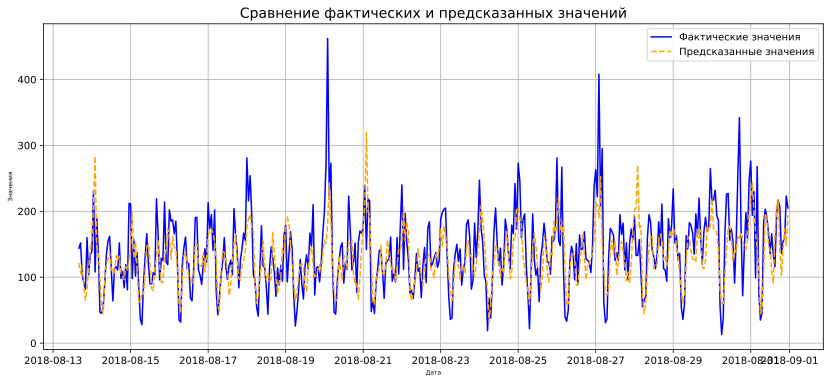

<Figure size 1008x432 with 0 Axes>

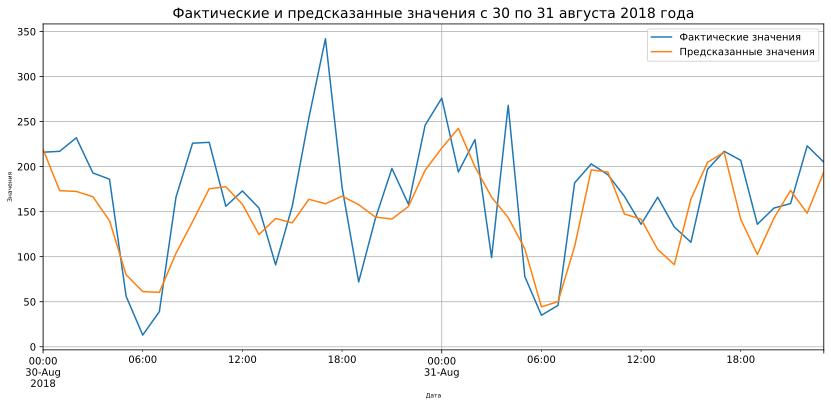

In [33]:
plot_predictions_vs_actuals(y_pred_mod, y_test)

RMSE на обучающей выборке: 45.8855, что соответствует требованиям заказчика

# Общий вывод
Выводы, полученные после изучения общей информации о датасете.
При чтении файла был заменен тип данных на datetime64 в признаке 'datetime'. В остальных признаках тип данных соответствует значениям. Пропусков в данных нет. Признак datetime при чтении таблицы установили равным индексу таблицы. Явных дубликатов в таблице нет. Данных достаточно для анализа. Данные расположены в хронологическом порядке.
Был построен график с учетом упорядочивания индекса (даты) в хронологическом порядке. Проведено ресемплирование, выбрав новый интервал временного ряда, равный 60 минутам. При ресемплировании данных по 1 дню и 1 месяцу четко виден восходящий тренд, временной ряд нестационарен, что будет мешать прогнозированию. При разложении временного ряда на тренд и сезонную компоненту также видны тренд и сезонность. Вычисление разности временного ряда и отображения на графике скользящего среднего и скользящего стандартного отклонения позволило сделать ряд более стационарным. При построении графика автокорреляции видно, что лаг 12 и 24 сильнее коррелируют с исходным рядом, чем соседние.
- Ridge:
Лучшие параметры: {'alpha': 0.001}
RMSE на обучающей выборке: 25.7127
Время обучения модели: 1.5273 секунд
Время прогнозирования: 0.0032 секунд;
- LGBMRegressor:
Лучшие параметры: {'num_leaves': 18, 'n_estimators': 18, 'max_depth': 6}
RMSE на обучающей выборке: 22.4434
Время обучения модели: 118.2943 секунд
Время прогнозирования: 0.0034 секунд
- SARIMAX, параметры были отобраны отдельно, так как их подбор занимает большое количество времени: order=(3, 1, 2), seasonal_order=(1, 1, 1, 24), 
Время обучения модели: 116.2273 секунд
Время предсказания: 0.0013 секунд
RMSE на тренировочной выборке: 22.2175

Лучший результат по скорости обучения показала модель Ridge, rmse на тестовых данных = 45.8855
Дополнительно хорошо бы соотносить данные с местом вызова такси для обеспечения необходимого количества водителей в загруженных локациях. Также при получении требований от заказчика необходимо уточнять требования относительно времени обучения и предсказания модели